# Asteroid orbit optimization with PyGMO - Design Space Exploration
Copyright (c) 2010-2022, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution  and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Context
This tutorial is the second part of the Asteroid Orbit Optimization example. This page uses the [Custom environment](https://tudat-space.readthedocs.io/en/latest/_src_getting_started/_src_examples/notebooks/pygmo/asteroid_orbit_optimization/aoo_custom_environment.html) part, without the explanation, after which the Design Space Exploration is explained.

## Problem recap

The 4 design variables are:
 - initial values of the semi-major axis.
 - initial eccentricity.
 - initial inclination.
 - initial longitude of the ascending node.
 
The 2 objectives are:
 - good coverage (maximizing the mean value of the absolute longitude w.r.t. Itokawa over the full propagation).
 - good resolution (the mean value of the distance should be minimized).
 
The constraints are set on the altitude: all the sets of design variables leading to an orbit.

It is assumed that the reader of this tutorial is already familiar with the content of [this basic PyGMO tutorial](https://tudat-space.readthedocs.io/en/latest/_src_resources/pygmo_basics.html).77

## Import statements

In [5]:
# Load standard modules
import os
import numpy as np
# Uncomment the following to make plots interactive
# %matplotlib widget
from matplotlib import pyplot as plt
from itertools import combinations as comb


# Load tudatpy modules
from tudatpy.io import save2txt
from tudatpy.kernel import constants
from tudatpy.kernel.interface import spice
from tudatpy.kernel.astro import element_conversion
from tudatpy.kernel.astro import frame_conversion
from tudatpy.kernel import numerical_simulation
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.util import pareto_optimums

# Load pygmo library
import pygmo as pg

current_dir = os.path.abspath('')

## Helpers
First of all, let's define a series of helper functions, which will later be used troughout this example.

### Itokawa rotation settings

In [6]:
def get_itokawa_rotation_settings(itokawa_body_frame_name):
    # Definition of initial Itokawa orientation conditions through the pole orientation
    pole_declination = np.deg2rad(-66.30)     # Declination
    pole_right_ascension = np.deg2rad(90.53)  # Right ascension
    meridian_at_epoch = 0.0                   # Meridian

    # Define initial Itokawa orientation in inertial frame (equatorial plane)
    initial_orientation_j2000 = frame_conversion.inertial_to_body_fixed_rotation_matrix(
        pole_declination, pole_right_ascension, meridian_at_epoch)
    
    # Get initial Itokawa orientation in inertial frame but in the Ecliptic plane
    initial_orientation_eclipj2000 = np.matmul(spice.compute_rotation_matrix_between_frames(
        "ECLIPJ2000", "J2000", 0.0), initial_orientation_j2000)

    # Manually check the results, if desired
    check_results = False
    if check_results:
        np.set_printoptions(precision=100)
        print(initial_orientation_j2000)
    
        print(initial_orientation_eclipj2000)

    # Compute rotation rate
    rotation_rate = np.deg2rad(712.143) / constants.JULIAN_DAY

    # Set up rotational model for Itokawa with constant angular velocity
    return environment_setup.rotation_model.simple(
        "ECLIPJ2000", itokawa_body_frame_name, initial_orientation_eclipj2000, 0.0, rotation_rate)

### Itokawa ephemeris settings

In [7]:
def get_itokawa_ephemeris_settings(sun_gravitational_parameter):
    # Define Itokawa initial Kepler elements
    itokawa_kepler_elements = np.array([
        1.324118017407799 * constants.ASTRONOMICAL_UNIT,
        0.2801166461882852,
        np.deg2rad(1.621303507642802),
        np.deg2rad(162.8147699851312),
        np.deg2rad(69.0803904880264),
        np.deg2rad(187.6327516838828)])
    
    # Convert mean anomaly to true anomaly
    itokawa_kepler_elements[5] = element_conversion.mean_to_true_anomaly(
        eccentricity=itokawa_kepler_elements[1],
        mean_anomaly=itokawa_kepler_elements[5])
    
    # Get epoch of initial Kepler elements (in Julian Days)
    kepler_elements_reference_julian_day = 2459000.5
    
    # Sets new reference epoch for Itokawa ephemerides (different from J2000)
    kepler_elements_reference_epoch = (kepler_elements_reference_julian_day - constants.JULIAN_DAY_ON_J2000) \
                                      * constants.JULIAN_DAY
    
    # Sets the ephemeris model
    return environment_setup.ephemeris.keplerian(
        itokawa_kepler_elements,
        kepler_elements_reference_epoch,
        sun_gravitational_parameter,
        "Sun",
        "ECLIPJ2000")

### Itokawa gravity field settings

In [8]:
def get_itokawa_gravity_field_settings(itokawa_body_fixed_frame, itokawa_radius):
    itokawa_gravitational_parameter = 2.36
    normalized_cosine_coefficients = np.array([
        [1.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0],
        [-0.145216, 0.0, 0.219420, 0.0, 0.0],
        [0.036115, -0.028139, -0.046894, 0.069022, 0.0],
        [0.087852, 0.034069, -0.123263, -0.030673, 0.150282]])
    normalized_sine_coefficients = np.array([
        [0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, -0.006137, -0.046894, 0.033976, 0.0],
        [0.0, 0.004870, 0.000098, -0.015026, 0.011627]])
    return environment_setup.gravity_field.spherical_harmonic(
        gravitational_parameter=itokawa_gravitational_parameter,
        reference_radius=itokawa_radius,
        normalized_cosine_coefficients=normalized_cosine_coefficients,
        normalized_sine_coefficients=normalized_sine_coefficients,
        associated_reference_frame=itokawa_body_fixed_frame)

### Itokawa shape settings

In [9]:
def get_itokawa_shape_settings(itokawa_radius):
    # Creates spherical shape settings
    return environment_setup.shape.spherical(itokawa_radius)

### Simulation bodies

In [10]:
def create_simulation_bodies(itokawa_radius):
    ### CELESTIAL BODIES ###
    # Define Itokawa body frame name
    itokawa_body_frame_name = "Itokawa_Frame"

    # Create default body settings for selected celestial bodies
    bodies_to_create = ["Sun", "Earth", "Jupiter", "Saturn", "Mars"]

    # Create default body settings for bodies_to_create, with "Earth"/"J2000" as
    # global frame origin and orientation. This environment will only be valid
    # in the indicated time range [simulation_start_epoch --- simulation_end_epoch]
    body_settings = environment_setup.get_default_body_settings(
        bodies_to_create,
        "SSB",
        "ECLIPJ2000")

    # Add Itokawa body
    body_settings.add_empty_settings("Itokawa")

    # Adds Itokawa settings
    # Gravity field
    body_settings.get("Itokawa").gravity_field_settings = get_itokawa_gravity_field_settings(itokawa_body_frame_name,
                                                                        itokawa_radius)
    # Rotational model
    body_settings.get("Itokawa").rotation_model_settings = get_itokawa_rotation_settings(itokawa_body_frame_name)
    # Ephemeris
    body_settings.get("Itokawa").ephemeris_settings = get_itokawa_ephemeris_settings(
        spice.get_body_gravitational_parameter( 'Sun') )
    # Shape (spherical)
    body_settings.get("Itokawa").shape_settings = get_itokawa_shape_settings(itokawa_radius)
    # Create system of selected bodies
    bodies = environment_setup.create_system_of_bodies(body_settings)

    ### VEHICLE BODY ###
    # Create vehicle object
    bodies.create_empty_body("Spacecraft")
    bodies.get("Spacecraft").set_constant_mass(400.0)

    # Create radiation pressure settings, and add to vehicle
    reference_area_radiation = 4.0
    radiation_pressure_coefficient = 1.2
    radiation_pressure_settings = environment_setup.radiation_pressure.cannonball(
        "Sun",
        reference_area_radiation,
        radiation_pressure_coefficient)
    environment_setup.add_radiation_pressure_interface(
        bodies,
        "Spacecraft",
        radiation_pressure_settings)

    return bodies

### Acceleration models

In [11]:
def get_acceleration_models(bodies_to_propagate, central_bodies, bodies):
    # Define accelerations acting on Spacecraft
    accelerations_settings_spacecraft = dict(
        Sun =     [ propagation_setup.acceleration.cannonball_radiation_pressure(),
                    propagation_setup.acceleration.point_mass_gravity() ],
        Itokawa = [ propagation_setup.acceleration.spherical_harmonic_gravity(3, 3) ],
        Jupiter = [ propagation_setup.acceleration.point_mass_gravity() ],
        Saturn =  [ propagation_setup.acceleration.point_mass_gravity() ],
        Mars =    [ propagation_setup.acceleration.point_mass_gravity() ],
        Earth =   [ propagation_setup.acceleration.point_mass_gravity() ]
    )

    # Create global accelerations settings dictionary
    acceleration_settings = {"Spacecraft": accelerations_settings_spacecraft}

    # Create acceleration models
    return propagation_setup.create_acceleration_models(
        bodies,
        acceleration_settings,
        bodies_to_propagate,
        central_bodies)

### Termination settings

In [12]:
def get_termination_settings(mission_initial_time, 
                             mission_duration,
                             minimum_distance_from_com,
                             maximum_distance_from_com):
    # Mission duration
    time_termination_settings = propagation_setup.propagator.time_termination(
        mission_initial_time + mission_duration,
        terminate_exactly_on_final_condition=False
    )
    # Upper altitude
    upper_altitude_termination_settings = propagation_setup.propagator.dependent_variable_termination(
        dependent_variable_settings=propagation_setup.dependent_variable.relative_distance('Spacecraft', 'Itokawa'),
        limit_value=maximum_distance_from_com,
        use_as_lower_limit=False,
        terminate_exactly_on_final_condition=False
    )
    # Lower altitude
    lower_altitude_termination_settings = propagation_setup.propagator.dependent_variable_termination(
        dependent_variable_settings=propagation_setup.dependent_variable.altitude('Spacecraft', 'Itokawa'),
        limit_value=minimum_distance_from_com,
        use_as_lower_limit=True,
        terminate_exactly_on_final_condition=False
    )

    # Define list of termination settings
    termination_settings_list = [time_termination_settings,
                                 upper_altitude_termination_settings,
                                 lower_altitude_termination_settings]

    return propagation_setup.propagator.hybrid_termination(termination_settings_list,
                                                           fulfill_single_condition=True)

### Dependent variables to save

In [13]:
def get_dependent_variables_to_save():
    dependent_variables_to_save = [
        propagation_setup.dependent_variable.central_body_fixed_spherical_position(
            "Spacecraft", "Itokawa"
        )
    ]
    return dependent_variables_to_save

## Optimisation problem formulation 
The optimisation problem can now be defined. This has to be done in a class that is compatible to what the PyGMO library can expect from this User Defined Problem (UDP). See [this page](https://esa.github.io/pygmo2/problem.html#pygmo.problem) from the PyGMO documentation as a reference. In this example, this class is called `AsteroidOrbitProblem`.

The `AsteroidOrbitProblem.__init__()` method is used to setup the problem. Most importantly, many problem-related objects are saved trough it: the system of bodie, the integrator settings, the propagator settings, the parameters that will later be used for the termination settings, and the design variables boundaries.

Then, the `AsteroidOrbitProblem.get_bounds()` function is used by PyGMO to define the search space. This function returns the boundaries of each design variable, as defined in the [pygmo.problem.get_bounds](https://esa.github.io/pygmo2/problem.html#pygmo.problem.get_bounds) documentation.

The `AsteroidOrbitProblem.get_nobj()` function is also used by PyGMO. It returns the number of objectives in the problem, in this case 2.

The last function used by PyGMO is `AsteroidOrbitProblem.fitness()`. As mentioned in the [pygmo.problem.fitness](https://esa.github.io/pygmo2/problem.html#pygmo.problem.fitness) documentation, PyGMO will input a given set of design variable to this function, that is expected to return a score associated with them. This is thus the cost function of the problem. In this case, this `AsteroidOrbitProblem.fitness()` runs a simulation using TudatPy based on the orbital elements that PyGMO inputs as design variables. Then, the score relative to the two optimisation objectives is computed and returned. Note that, in PyGMO, this fitness function will always be **minimised**. To **maximise** objectives instead, the fitness that is returned will have to be for instance inversed. This is why, because we want to maximise the coverage, the fitness for this objective is computed as the inverse of the mean latitudes. If the mean of the latitudes is high, the coverage is high, which is closer to the optimum. Because this better value is higher than worse values, we return the fitness as the inverse of the mean latitudes.

One more function is included, `AsteroidOrbitProblem.get_last_run_dynamics_simulator()`. This allows to get the dynamic simulator of the last simulation that was run in the problem.

In [14]:
class AsteroidOrbitProblem:
    
    def __init__(self,
                 bodies,
                 integrator_settings,
                 propagator_settings,
                 mission_initial_time,
                 mission_duration,
                 design_variable_lower_boundaries,
                 design_variable_upper_boundaries):
        
        # Sets input arguments as lambda function attributes
        # NOTE: this is done so that the class is "pickable", i.e., can be serialized by pygmo
        self.bodies_function = lambda: bodies
        self.integrator_settings_function = lambda: integrator_settings
        self.propagator_settings_function = lambda: propagator_settings
        
        # Initialize empty dynamics simulator
        self.dynamics_simulator_function = lambda: None
        
        # Set other input arguments as regular attributes
        self.mission_initial_time = mission_initial_time
        self.mission_duration = mission_duration
        self.mission_final_time = mission_initial_time + mission_duration
        self.design_variable_lower_boundaries = design_variable_lower_boundaries
        self.design_variable_upper_boundaries = design_variable_upper_boundaries

    def get_bounds(self):
        return (list(self.design_variable_lower_boundaries), list(self.design_variable_upper_boundaries))

    def get_nobj(self):
        return 2

    def fitness(self,
                orbit_parameters):
        # Retrieves system of bodies
        current_bodies = self.bodies_function()
        
        # Retrieves Itokawa gravitational parameter
        itokawa_gravitational_parameter = current_bodies.get("Itokawa").gravitational_parameter
        
        # Reset the initial state from the design variable vector
        new_initial_state = element_conversion.keplerian_to_cartesian_elementwise(
            gravitational_parameter=itokawa_gravitational_parameter,
            semi_major_axis=orbit_parameters[0],
            eccentricity=orbit_parameters[1],
            inclination=np.deg2rad(orbit_parameters[2]),
            argument_of_periapsis=np.deg2rad(235.7),
            longitude_of_ascending_node=np.deg2rad(orbit_parameters[3]),
            true_anomaly=np.deg2rad(139.87))
        
        # Retrieves propagator settings object
        propagator_settings = self.propagator_settings_function()
        
        # Retrieves integrator settings object
        integrator_settings = self.integrator_settings_function()
        
        # Reset the initial state
        propagator_settings.initial_states = new_initial_state

        # Propagate orbit
        dynamics_simulator = numerical_simulation.SingleArcSimulator(   current_bodies,
                                                                        integrator_settings,
                                                                        propagator_settings,
                                                                        print_dependent_variable_data=False,
                                                                        print_state_data=False)
        # Update dynamics simulator function
        self.dynamics_simulator_function = lambda: dynamics_simulator

        # Retrieve dependent variable history
        dependent_variables = dynamics_simulator.dependent_variable_history
        dependent_variables_list = np.vstack(list(dependent_variables.values()))
        
        # Retrieve distance
        distance = dependent_variables_list[:, 0]
        # Retrieve latitude
        latitudes = dependent_variables_list[:, 1]
        
        # Compute mean latitude
        mean_latitude = np.mean(np.absolute(latitudes))
        # Computes fitness as mean latitude
        current_fitness = 1.0 / mean_latitude

        # Exaggerate fitness value if the spacecraft has broken out of the selected distance range
        current_penalty = 0.0
        if (max(dynamics_simulator.dependent_variable_history.keys()) < self.mission_final_time):
            current_penalty = 1.0E2

        return [current_fitness + current_penalty, np.mean(distance) + current_penalty * 1.0E3]

    def get_last_run_dynamics_simulator(self):
        return self.dynamics_simulator_function()

### Setup orbital simulation
Before running the optimisation, some aspect of the orbital simulation around Itokawa still need to be setup.
Most importantly, the simulation bodies, acceleration models, integrator settings, and propagator settings, all have to be defined. To do so, the helpers that were defined above are used.

#### Simulation settings
The simulation settings are first defined.

The SPICE kernels are loaded, so that we can acess the gravitational parameter of the Sun in the `create_simulation_bodies()` function.

The definition of the termination parameters follows, with a maximum mission duration of 5 Earth days. The altitude range above Itokawa is also defined between 150 meters and 5 km.

Follows the definition of the design variable range, that PyGMO will use during the optimisation. This range is as follows:
 - Initial semi-major axis between 300 and 2000 meters.
 - Initial eccentricity between 0 and 0.3.
 - Initial inclination between 0 and 180 deg.
 - Initial longitude of the ascending node between 0 and 360 deg.
 
The system of bodies is then setup using the `create_simulation_bodies()` helper, and a radius for Itokawa of 161.915 meters.

Finally, the acceleration models are setup using the `get_acceleration_models()` helper.

In [15]:
# Load spice kernels
spice.load_standard_kernels()

# Set simulation start and end epochs
mission_initial_time = 0.0
mission_duration = 5.0 * constants.JULIAN_DAY

# Define Itokawa radius
itokawa_radius = 161.915

# Set altitude termination conditions
minimum_distance_from_com = 150.0 + itokawa_radius
maximum_distance_from_com = 5.0E3 + itokawa_radius

# Set boundaries on the design variables
design_variable_lb = (300, 0.0, 0.0, 0.0)
design_variable_ub = (2000, 0.3, 180, 360)

# Create simulation bodies
bodies = create_simulation_bodies(itokawa_radius)

# Define bodies to propagate and central bodies
bodies_to_propagate = ["Spacecraft"]
central_bodies = ["Itokawa"]

# Create acceleration models
acceleration_models = get_acceleration_models(bodies_to_propagate, central_bodies, bodies)

#### Dependent variables, termination settings, and orbit parameters
To define the propagator settings in the subsequent sections, we first call the `get_dependent_variables_to_save()` and `get_termination_settings()` helpers to define the dependent variables and termination settings.

The `orbit_parameters` list is defined from a `final_population.dat` file from the optimization. This is not crucial, but the choice of value will help in the Design Space Exploration below; one should have a feasible set of orbit parameters if the variation is only done one-by-one. If all parameters are changed simultaneously, which is also useful for different reasons, then the initial state is of no matter.

In [16]:
# Define list of dependent variables to save
dependent_variables_to_save = get_dependent_variables_to_save()

# Create propagation settings
termination_settings = get_termination_settings(
    mission_initial_time, mission_duration, minimum_distance_from_com, maximum_distance_from_com)

orbit_parameters = [5.583550664266383592e+02, # these parameters came from the final_Population.dat of asteroid example
                        2.277775134218668063e-01, 
                        1.088190920952768010e+02,
                        6.596503208981977195e+01]

#### Integrator and Propagator settings
Let's now define the integrator settings. In this case, a variable step integration scheme is used, with the followings:
 - RKF7(8) coefficient set.
 - Initial time step of 1 sec.
 - Minimum and maximum time steps of 1E-6 sec and 1 Earth day.
 - Relative and absolute error tolerances of 1E-8.

Then, we define pure translational propagation settings with a Cowell propagator. The initial state is set to 0 for both the position and the velocity. This is because the initial state will later be changed in the `AsteroidOrbitProblem.fitness()` function during the optimisation.

In [17]:
# Create numerical integrator settings
integrator_settings = propagation_setup.integrator.runge_kutta_variable_step_size(
    initial_time=mission_initial_time,
    initial_time_step=1.0,
    coefficient_set=propagation_setup.integrator.CoefficientSets.rkf_78,
    minimum_step_size=1.0E-6,
    maximum_step_size=constants.JULIAN_DAY,
    relative_error_tolerance=1.0E-8,
    absolute_error_tolerance=1.0E-8)

# Get current propagator, and define translational state propagation settings
propagator = propagation_setup.propagator.cowell
# Define propagation settings
initial_state = np.zeros(6)
propagator_settings = propagation_setup.propagator.translational(central_bodies,
                                                                         acceleration_models,
                                                                         bodies_to_propagate,
                                                                         initial_state,
                                                                         termination_settings,
                                                                         propagator,
                                                                         dependent_variables_to_save)

## Design Space Exploration
Now that the simulation has been setup, the problem can actually be run and explored. While one could jump into the optimalisation immediately, not much is known yet about the specific problem at hand. A design space exploration is done prior to the optimalisation in order to better understand the behaviour of the system. The goal is to figure out and observe the link between the design space and the objective space. Numerous methods for exploring the design space are possible, a list of the implemented methods can be seen below. This selection covers various kinds of analysis, ranging from simple and brainless, to systematic and focussed. 

- Monte Carlo Analysis
- Fractional Factorial Design
- Factorial Design

### Monte Carlo Analysis
Starting with the method that requires the least amount of thinking; a Monte Carlo Analysis. By varying input parameters randomly, and propagating many trajectories, one can discover trends; how the semi-major axis influences the mean latitude objective, for example. The difficulty arises in that the results are not conclusive; design variables can be coupled by definition.

#### Variable Definitions

A number of variables have to be defined. The number of runs per design variable, this quantity is a trade-off between resolution of your results and time spent. The seed is defined for reproducibility of the results. A number of arrays are defined for saving the data relevant for post-processing. 

In [18]:
no_of_runs = 500
random_seed = 42

np.random.seed(random_seed)

orbit_param_names = ['Semi-major Axis', 'Eccentricity', 'Inclination', 'Longitude of the Node']
mean_latitude_all_param = np.zeros((no_of_runs, len(orbit_param_names)))
mean_distance_all_param = np.zeros((no_of_runs, len(orbit_param_names)))
max_distance = np.zeros((no_of_runs, len(orbit_param_names)))
min_distance = np.zeros((no_of_runs, len(orbit_param_names)))
constraint_values = np.zeros((no_of_runs, len(orbit_param_names)))
parameters = np.zeros((no_of_runs, len(orbit_param_names)))

#### Monte Carlo loop

The Monte Carlo variation is made with two nested loops; one for the various orbit parameters that will be changed, and one for each run. As explained before, only one parameter is changed per run, so for each parameter, a set of random numbers is produced equal to the number of simulations. This new combination is throughput into the fitness function of the `AsteroidOrbitProblem` class. Regarding that `AsteroidOrbitProblem` class, for the sake of consistency, the (UDP) Problem class from PyGMO is used. This class is by no means necessary for running the analysis. After the fitness is evaluated, a number of relevant quantities are saved to the previously defined arrays.

In [19]:
for i in range(len(orbit_parameters)): 

    #print('Monte Carlo design variable :', orbit_param_names[i])
    parameter_all_runs = np.random.uniform(design_variable_lb[i], design_variable_ub[i], no_of_runs)
    parameters[:, i] = parameter_all_runs


    for j in range(no_of_runs):
        #print('Monte Carlo Run :', str(j))

        initial_state[i] = parameter_all_runs[j]
        orbit_parameters[i] = parameter_all_runs[j]

        # Create Asteroid Orbit Problem object
        current_asteroid_orbit_problem = AsteroidOrbitProblem(bodies,
                                                                      integrator_settings,
                                                                      propagator_settings,
                                                                      mission_initial_time,
                                                                      mission_duration,
                                                                      design_variable_lb,
                                                                      design_variable_ub
                                                                      )

        # Update thrust settings and evaluate fitness
        current_asteroid_orbit_problem.fitness(orbit_parameters)

        ### OUTPUT OF THE SIMULATION ###
        # Retrieve propagated state and dependent variables
        state_history = current_asteroid_orbit_problem.get_last_run_dynamics_simulator().state_history
        dependent_variable_history = current_asteroid_orbit_problem.get_last_run_dynamics_simulator().dependent_variable_history

        # Get the number of function evaluations (for comparison of different integrators)
        dynamics_simulator = current_asteroid_orbit_problem.get_last_run_dynamics_simulator()
        function_evaluation_dict = dynamics_simulator.cumulative_number_of_function_evaluations
        number_of_function_evaluations = list(function_evaluation_dict.values())[-1]

        dependent_variables_list = np.vstack(list(dependent_variable_history.values()))
        # Retrieve distance
        distance = dependent_variables_list[:, 0]
        # Retrieve latitude
        latitudes = dependent_variables_list[:, 1]
        # Compute mean latitude
        mean_latitude = np.mean(np.absolute(latitudes))
        # Compute mean distance
        mean_distance = np.mean(distance)  

        # Objectives
        mean_latitude_all_param[j, i] = mean_latitude
        mean_distance_all_param[j, i] = mean_distance

        max_dist = np.max(distance)
        min_dist = np.min(distance)

        
        dist_to_max = maximum_distance_from_com - max_dist
        dist_to_min = minimum_distance_from_com - min_dist

        if np.abs(dist_to_max) > np.abs(dist_to_min):
            constraint_val = np.abs(dist_to_min)
            maxmin = 'min'
        else:
            constraint_val = np.abs(dist_to_max)
            maxmin = 'max'
        constraint_values[j, i] = constraint_val


####  Monte Carlo Post-processing
A few dictionaries are defined for labelling purposes and the parameters are scattered against the objective values. A color map is used to indicate how close the solutions are to the distance constraint value. Many results are made, but only the semi-major axis variation data is plotted. Remove `break` in the nested loop below to obtain all results.

In [20]:
# Create dictionaries defining the design variables
design_variable_names = {0: 'Semi-major axis [m]',
                           1: 'Eccentricity',
                           2: 'Inclination [deg]',
                           3: 'Longitude of the node [deg]'}
design_variable_range = {0: [800.0, 1300.0],
                           1: [0.10, 0.17],
                           2: [90.0, 95.0],
                           3: [250.0, 270.0]}
design_variable_symbols = {0: r'$a$',
                             1: r'$e$',
                             2: r'$i$',
                             3: r'$\Omega$'}
design_variable_units = {0: r' m',
                           1: r' ',
                           2: r' deg',
                           3: r' deg'}

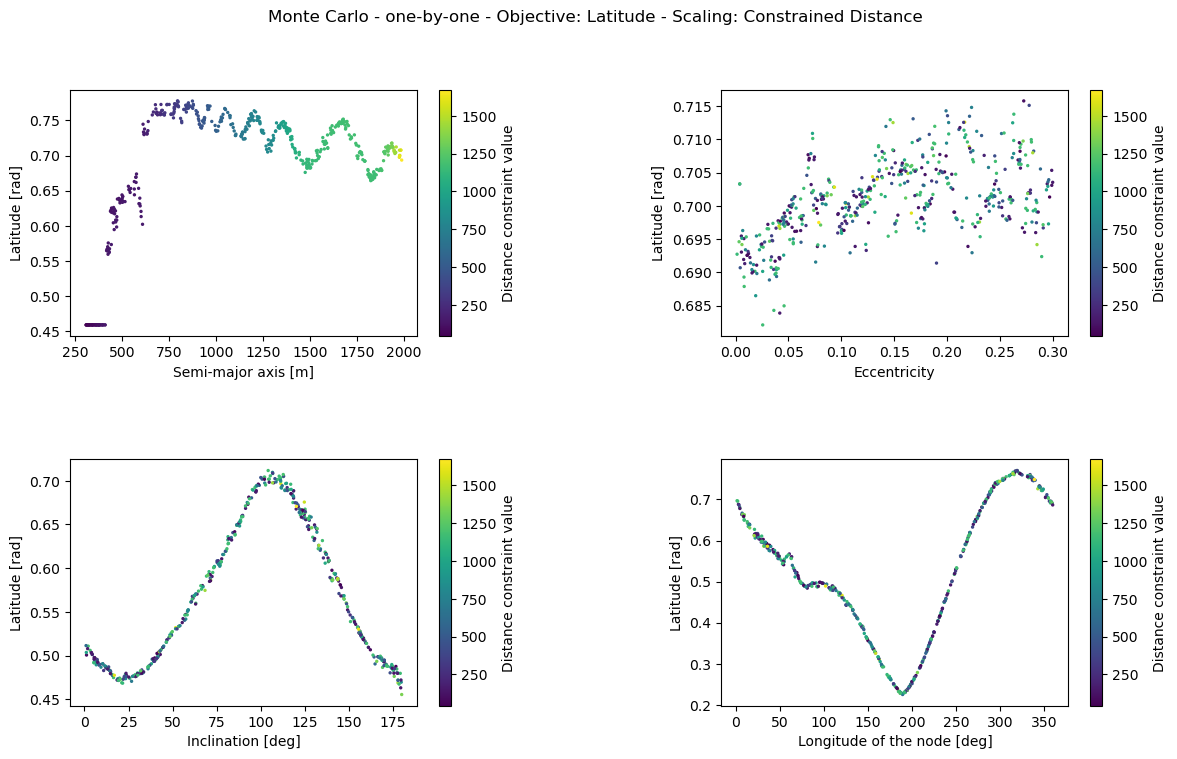

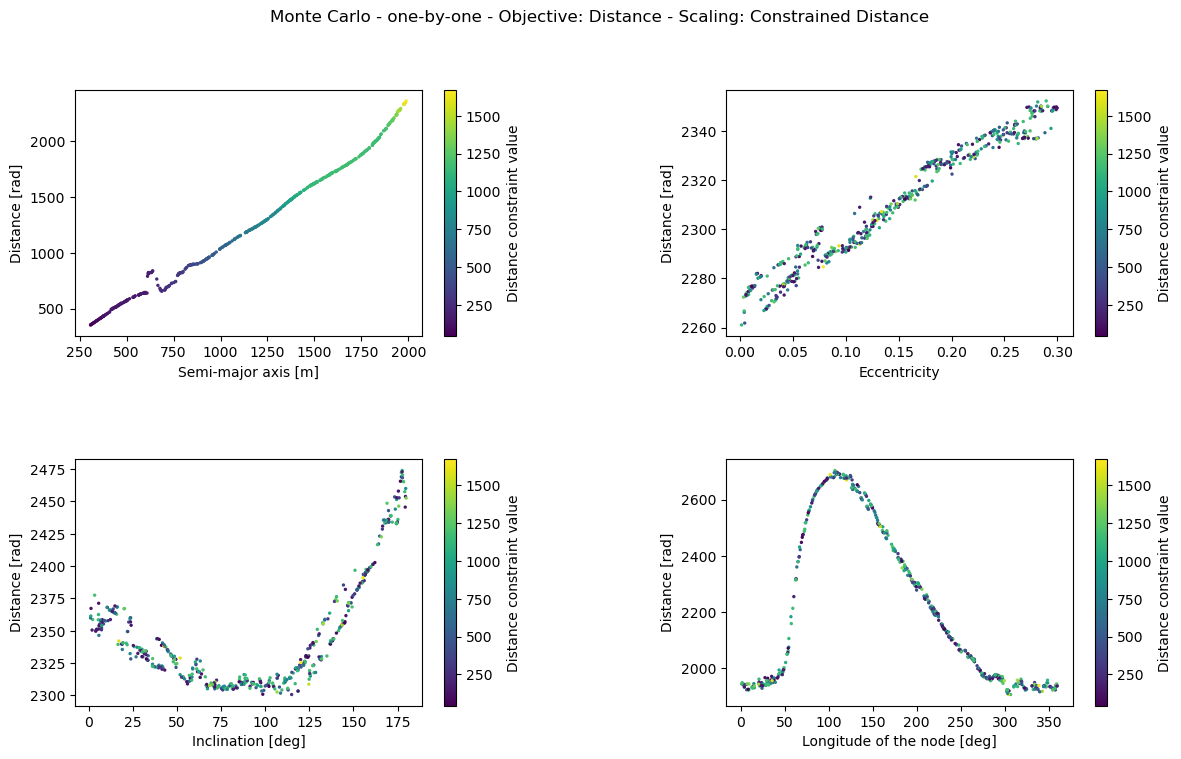

In [21]:
obj_arrays = [mean_latitude_all_param, mean_distance_all_param]
objective_names = ['Latitude', 'Distance']
for obj in range(2): #number of objectives

    for i in range(len(orbit_param_names)):
        fig, axs = plt.subplots(2, 2, figsize=(14, 8))
        plt.subplots_adjust(wspace=0.5, hspace=0.5)
        fig.suptitle('Monte Carlo - one-by-one - Objective: %s - Scaling: Constrained Distance'%(objective_names[obj]))
        for ax_index, ax in enumerate(axs.flatten()):
            cs = ax.scatter(parameters[:, ax_index], obj_arrays[obj][:, ax_index], s=2, c=constraint_values[:,i])
            cbar = fig.colorbar(cs, ax=ax)
            cbar.ax.set_ylabel('Distance constraint value')
            ax.set_ylabel('%s [rad]'%(objective_names[obj]))
            ax.set_xlabel(design_variable_names[ax_index])
        
        #For more verbose results, remove the 'break' below.
        break

### Fractional Factorial Design
The Fractional Factorial Design (FFD) method has a number of pros and cons relative to the Monte Carlo method. The concept is based on orthogonality of a design matrix, with which you can extract information efficiently without running a ton of simulations. In other words, a selection of corners of the design space hypercube are explored. The advantage of the orthogonal array, based on Latin Squares, is that it is computationally very light, thereby of course sacrificing knowledge about your design space. The information per run is high with FFD.

#### Orthogonal Array

A function is defined that calculates the orthogonal array depending on the number of levels (2 or 3) and number of factors (design variables) that any specific problem has. The algorithm is based on the Latin Square and the array is systematically built from there. If you print the array that rolls out, you can get a feel for the structure of the method and the reason why it is efficient.

In [22]:
def orth_arrays(nfact : int, nlevels : int) -> tuple((np.array, int)):
    """ 
    Create orthogonal arrays from Latin Square in 4 successive steps:
    
    0) Take the column from the smaller array to create 2 new
       columns and 2x new rows,
    1) block 1 (1/2 rows): take old values 2x for new columns,
    2) block 2 (1/2 rows): take old values, use Latin-Square for new
       columns,
    3) column 1: divide experiments into groups of 1,2.
    """

    ierror = 0
    icount = 0

    row_number = lambda icount, nlevels : nlevels**(icount+1)
    col_number = lambda row_number : row_number-1

    if nlevels == 2:

        if nfact >= 2 and nfact <= 3:
                icount = 1
        elif nfact >= 4 and nfact <= 7:
                icount = 2
        elif nfact >= 8 and nfact <= 15:
                icount = 3
        elif nfact >= 16 and nfact <= 31:
                icount = 4
        elif nfact >= 32 and nfact <= 63:
                icount = 5
        elif nfact >= 64 and nfact <= 127:
                icount = 6
        elif nfact >= 128 and nfact <= 255:
                icount = 7
        else:
                ierror = 1
                Lx = np.zeros(1)
                return Lx, ierror

        Lxrow = row_number(icount, nlevels)
        Lxcol = col_number(Lxrow)
        Lx = np.zeros((Lxrow,Lxcol))
        iaux = Lx.copy()
        
        ### Define the 2-level Latin Square ###
        
        index_list = [0, 1]
        two_level = [-1, 1]
        LS = np.zeros((2,2))
        LS[0,0] = -1
        LS[0,1] =  1
        LS[1,0] =  1
        LS[1,1] = -1
        
        # In case of only one factor, copy the first Latin Square and leave the subroutine.
        
        if icount == 0:
                Lx[0,0] = LS[0,1]
                Lx[1,0] = LS[0,1]
                return Lx, ierror
        
        iaux[0,0] = -1
        iaux[1,0] =  1
        irow = 2
        icol = 1

        # Algorithm in Matlab starts from index 1
        Lx = np.hstack((np.zeros((len(Lx), 1)), Lx))
        Lx = np.vstack((np.zeros((1, len(Lx[0,:]))), Lx))
        iaux = np.hstack((np.zeros((len(iaux), 1)), iaux))
        iaux = np.vstack((np.zeros((1, len(iaux[0,:]))), iaux))
        
        ### Fill in orthogonal array ###

        for i1 in range(1, icount + 1):
                for i2 in range(1, irow + 1):
                        for i3 in range(1, icol + 1):
                                for p in range(2):
                                        for q in range(2):
                                                for r in range(2):

                                                        #Block 1.
                                                        if iaux[i2,i3] == two_level[q] and p == 0:
                                                                Lx[i2,i3*2 + index_list[r]] = two_level[q] 

                                                        #Block 2
                                                        if iaux[i2,i3] == two_level[q] and p == 1:
                                                                Lx[i2 + irow,i3*2 + index_list[r]] = LS[index_list[q], index_list[r]]


                                        Lx[i2 + irow*p,1] = two_level[p]

                if i1 == icount:
                        # Deleting extra row from Matlab artifact
                        Lx = np.delete(Lx, 0, 0)
                        Lx = np.delete(Lx, 0, 1)
                        return Lx, ierror
                irow = 2*irow
                icol = 2*icol+1
                for i2 in range(1, irow + 1):
                        for i3 in range(1, icol + 1):
                                iaux[i2,i3] = Lx[i2,i3]

    elif nlevels == 3:

        if nfact >= 2 and nfact <= 4:
                icount = 1
        elif nfact >= 5 and nfact <= 13:
                icount = 2
        elif nfact >= 14 and nfact <= 40:
                icount = 3
        elif nfact >= 41 and nfact <= 121:
                icount = 4
        else:
                ierror = 1
                Lx = np.zeros(1)
                return Lx, ierror

        #Lxrow = 3**(icount+1)
        #Lxcol = (Lxrow - 1) // 2 # why // 2 -> check
        Lxrow = row_number(icount, nlevels)
        Lxcol = col_number(Lxrow) // 2
        Lx = np.zeros((Lxrow,Lxcol))
        iaux = Lx.copy()


        
        ### Define the two three-level Latin Squares. Latin Square 1 ###
        index_list = [0, 1, 2]
        
        LS1 = np.zeros((3,3))
        three_level = [-1, 0, 1]
        for i in range(3):
                for j in range(3):
                                LS1[i,index_list[j]] = three_level[(j+i)%3];
                                
         
        ### ... and Latin Square 2. ###
         
        LS2 = np.zeros((3,3))
        three_level_2 = [-1, 1, 0]
        for i in range(3):
                for j in range(3):
                        LS2[i, index_list[j]] = three_level_2[j-i]
         
        ### In case of only one factor, copy the first Latin Square and leave the subroutine. ###
         
        if icount == 0:
           Lx[0,0] = LS1[0,0];
           Lx[1,0] = LS1[0,1];
           Lx[2,0] = LS1[0,2];
           return Lx, ierror

        ### Define iaux for loops ###
        iaux[0,0] = -1
        iaux[1,0] = 0
        iaux[2,0] =  1
        irow = 3
        icol = 1

        #Algorithm in Matlab starts from index 1
        Lx = np.hstack((np.zeros((len(Lx), 1)), Lx))
        Lx = np.vstack((np.zeros((1, len(Lx[0,:]))), Lx))
        iaux = np.hstack((np.zeros((len(iaux), 1)), iaux))
        iaux = np.vstack((np.zeros((1, len(iaux[0,:]))), iaux))
        
        ### Filling in Lx ###
        for i1 in range(1, icount + 1):
                for i2 in range(1, irow + 1):
                        for i3 in range(1, icol + 1):
                                for p in range(3):
                                        for q in range(3):
                                                for r in range(3):

                                                        #Block 1.

                                                        if iaux[i2,i3] == three_level[q] and p == 0:
                                                                Lx[i2 + irow*p,i3*3 + three_level[r]] = three_level[q] 

                                                        #Block 2.

                                                        if iaux[i2,i3] == three_level[q] and p == 1:
                                                                Lx[i2 + irow*p,i3*3 + three_level[r]] = LS1[index_list[q], index_list[r]]

                                                        #Block 3.

                                                        if iaux[i2,i3] == three_level[q] and p == 2:
                                                                Lx[i2 + irow*p,i3*3 + three_level[r]] = LS2[index_list[q], index_list[r]]

                                        Lx[i2 + irow*p,1] = three_level[p]

                if i1 == icount:
                        # Deleting extra row from Matlab artifact
                        Lx = np.delete(Lx, 0, 0)
                        Lx = np.delete(Lx, 0, 1)
                        return Lx, ierror
                irow = 3*irow
                icol = 3*icol+1
                for i2 in range(1, irow + 1):
                        for i3 in range(1, icol + 1):
                                iaux[i2,i3] = Lx[i2,i3]
    else:
        print('These levels are not implemented yet. (You may wonder whether you need them)')


#### Fractional Factorial Design Loop 

The FFD module is similar to that of the Monte Carlo in that there are two loops including one that changes the design variables and one that loops over the various runs. Within the two loops the `AsteroidOrbitProblem` is defined again and the objective values are extracted after evaluating the fitness function.

The difference is in how the orbit parameters are assigned. Instead of creating vectors of random numbers, the values in the orthogonal array, -1 and 1 for 2-level analysis, map to minimum and maximum orbit parameter values respectively.

In [23]:
no_of_factors = 4 # This leads to an 8x7 orthogonal array. Meaning 7 contribution percentages will be given in the ANOVA.
no_of_levels = 2

FFD_array, ierror = orth_arrays(no_of_factors, no_of_levels)
mean_dependent_variables_list = np.zeros((len(FFD_array), 2)) # the second argument is the number of objectives

for i in range(len(FFD_array)):
    for j in range(len(orbit_parameters)):
        
        if FFD_array[i,j] == -1:
            orbit_parameters[j] = design_variable_lb[j]
        else: # if two level orthogonal array
            orbit_parameters[j] = design_variable_ub[j]

    # Create Asteroid Orbit Problem object
    current_asteroid_orbit_problem = AsteroidOrbitProblem(bodies,
                                                  integrator_settings,
                                                  propagator_settings,
                                                  mission_initial_time,
                                                  mission_duration,
                                                  design_variable_lb,
                                                  design_variable_ub
                                                  )
    # Update orbital parameters and evaluate fitness
    current_asteroid_orbit_problem.fitness(orbit_parameters)

    ### OUTPUT OF THE SIMULATION ###
    # Retrieve propagated state and dependent variables
    state_history = current_asteroid_orbit_problem.get_last_run_dynamics_simulator().state_history
    dependent_variable_history = current_asteroid_orbit_problem.get_last_run_dynamics_simulator().dependent_variable_history

    dependent_variables_list = np.vstack(list(dependent_variable_history.values()))
    # Retrieve distance
    distance = dependent_variables_list[:, 0]
    # Retrieve latitude
    latitudes = dependent_variables_list[:, 1]
    # Compute mean latitude
    mean_latitude = np.mean(np.absolute(latitudes))
    # Compute mean distance
    mean_distance = np.mean(distance)

    mean_dependent_variables_list[i, 0] = mean_distance
    mean_dependent_variables_list[i, 1] = mean_latitude

#### Post-processing FFD
As not many runs are done, plotting any data is not sensible. An Analysis of Variance (ANOVA) can be done to determine percentage contributions of each parameter. For example, one would find that the eccentricity—one of the design variables—has a x% contribution to the distance objective.

This ANOVA analysis can also be done on the Factorial Design method discussed below, and so in the interest of space it is only applied there.

### Factorial Design

Factorial design (FD) is another systematic approach to exploring the design space. It can be very useful as far fewer assumptions are made, all corners—and potentially intermediate points—of the hypercube are tested. Whereas with FFD an orthogonal array was created with Latin Squares, here the array is built using Yates algorithm. Some information can be found [here](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35i.htm).

#### Yates Array
Yates array also utilized the two level approach where the array is filled with -1 and 1 corresponding to a maximum value or minimum value. This array has many more rows, because each possible combination of - and + is used.


In [24]:
def yates_array(no_of_levels : int, no_of_factors : int) -> np.array:
    """
    Function that creates a yates array according to yates algorithm

    no_of_levels : The number of levels a factor can attain

    no_of_factors : The number of design variables in the problem

    Return : np.array (no_of_levels**no_of_factors, no_of_factors)

    """
    if no_of_levels == 2: #for the ANOVA analysis with interactions
        levels = [-1, 1]
    elif no_of_levels == 7: #for the response surfaces
        levels = [-3, -2, -1, 0, 1, 2, 3]
    else:
        print("The number of levels you have requested is not implemented yet")

    n_rows = no_of_levels**no_of_factors
    n_cols = no_of_factors
    yates_array = np.zeros((n_rows, n_cols), dtype='int')

    row_seg = n_rows
    for col in range(n_cols):
        repetition_amount = no_of_levels**col # Number of times to repeat the row segment to fill the array
        row_seg = row_seg // no_of_levels # Get row segment divided by number of levels
        for j in range(repetition_amount):
            for it, level in enumerate(levels):
                # fill in from position i to position i + no_of_levels
                yates_array[(it*row_seg + j*row_seg*no_of_levels):((it+1)*row_seg +
                j*row_seg*no_of_levels), col] = levels[it] 
    return yates_array 


#### Anova Analysis

Now that yates array (an orthogonal array) has been created and the objective values have been obtained, these two pieces of data can be combined to calculate what the contribution is of a certain variable or interaction to an objective. Individual, linear, and quadratic effects are can be taken into account when determining the contributions.

In [25]:
def anova_analysis(objective_values, 
                   factorial_design_array : np.array, 
                   no_of_factors=4, 
                   no_of_levels=2,
                   level_of_interactions=2):
    """
    Function that performs an ANOVA for 2 levels and n factors. After some definitions, we iterate
    through yates array, depending on the value being -1 or 1, we add the occurrence to a certain
    container. Later the amount of items in the container determines the contribution of that
    specific variable to an objective value. This iteration is done for individual, linear, and
    quadratic effects, thereby determing the contribution of all interactions.

    objective_values : list of objective function values following from the factorial design array

    factorial_design_array : np.array from yates_array function

    level_of_interactions : Integer either 2 or 3, depending on what interactions you want to
    include

    Return : This analysis returns the contributions of all parameters/interactions to the
    specified objective. Specifically, it returns 4 elements: Pi, Pij, Pijk, and Pe. These are lists
    that contain percentage contributions to the objective. Pi are the individual parameters, Pij
    are linear interactions, and Pijk are the quadratic interactions. Pe are errors.

    """

    assert len(objective_values) == len(factorial_design_array) # Quick check for validity of data

    number_of_simulations = no_of_levels ** no_of_factors

    #########################
    ### Array definitions ###
    #########################

    # Lambda function to determine number of interaction columns
    interactions = lambda iterable, k : [i for i in comb(range(iterable), k)]
    no_of_interactions_2 = interactions(no_of_factors, 2) # number of 2-level interactions
    no_of_interactions_3 = interactions(no_of_factors, 3) # number of 3-level interactions

    # Arrays for individual, 2, and 3 level interactions - sum of squares
    sum_of_squares_i = np.zeros(no_of_factors)
    sum_of_squares_ij = np.zeros(len(no_of_interactions_2))
    sum_of_squares_ijk = np.zeros(len(no_of_interactions_3))

    #Arrays for individual, 2, and 3 level interactions - percentage contribution
    percentage_contribution_i = np.zeros(no_of_factors)
    percentage_contribution_ij = np.zeros(len(no_of_interactions_2))
    percentage_contribution_ijk = np.zeros(len(no_of_interactions_3))

    # Sum of objective values and mean of parameters
    sum_of_objective = np.sum(objective_values)
    mean_of_param = sum_of_objective/number_of_simulations

    # Variance and standard deviation of data
    variance_per_run = np.zeros(number_of_simulations)
    objective_values_squared = np.zeros(number_of_simulations)
    for i in range(len(factorial_design_array)):
        variance_per_run[i] = (objective_values[i] - mean_of_param)**2 / (number_of_simulations-1)
        objective_values_squared[i] = objective_values[i]**2
    variance = np.sum(variance_per_run)
    standard_deviation = np.sqrt(variance)
    
    # Square of sums
    CF = sum_of_objective * mean_of_param
    # Difference square of sums and sum of squares
    sum_of_deviation = np.sum(objective_values_squared) - CF

    #####################################
    ### Iterations through yates array ###
    #####################################

    ### Linear effects ###
    # Container for appearance of minimum/maximum value
    Saux = np.zeros((no_of_factors, no_of_levels))
    number_of_appearanes = number_of_simulations/no_of_levels
    for j in range(number_of_simulations):
        for i in range(no_of_factors):
            if factorial_design_array[j,i] == -1:
                Saux[i, 0] += objective_values[j]
            else:
                Saux[i, 1] += objective_values[j]


    if sum_of_deviation > 1e-6: # If there is a deviation, then there is a contribution.
        for i in range(no_of_factors):
            sum_of_squares_i[i] = (1/2)*(Saux[i, 1] - Saux[i, 0])**2/number_of_appearanes
            percentage_contribution_i[i] = 100 * sum_of_squares_i[i]/sum_of_deviation

    ### 2-level interaction ###
    # Container for appearance of minimum/maximum value
    Saux = np.zeros((len(no_of_interactions_2), no_of_levels))
    for j in range(number_of_simulations):
        for i in range(len(no_of_interactions_2)):
            # Interaction sequence of all possible 2-level interactions is created by multiplying the
            # two respective elements from yates array
            interaction = factorial_design_array[j, no_of_interactions_2[i][0]] * \
                            factorial_design_array[j, no_of_interactions_2[i][1]]
            if interaction == -1:
                Saux[i, 0] += objective_values[j]
            else:
                Saux[i, 1] += objective_values[j]

    if sum_of_deviation > 1e-6: # If there is a deviation, then there is a contribution.
        for i in range(len(no_of_interactions_2)):
            sum_of_squares_ij[i] = (1/2)*(Saux[i, 1] - Saux[i, 0])**2/number_of_appearanes
            percentage_contribution_ij[i] = 100 * sum_of_squares_ij[i]/sum_of_deviation

    ### 3-level interaction ###
    # Container for appearance of minimum/maximum value
    Saux = np.zeros((len(no_of_interactions_3), no_of_levels))
    for j in range(number_of_simulations):
        for i in range(len(no_of_interactions_3)):
            # Interaction sequence of all possible 3-level interactions is created by multiplying the
            # three respective elements from yates array
            interaction = factorial_design_array[j, no_of_interactions_3[i][0]] * \
                            factorial_design_array[j, no_of_interactions_3[i][1]] * \
                              factorial_design_array[j, no_of_interactions_3[i][2]]
            if interaction == -1:
                Saux[i, 0] += objective_values[j]
            else:
                Saux[i, 1] += objective_values[j]

    if sum_of_deviation > 1e-6: # If there is a deviation, then there is a contribution.
        for i in range(len(no_of_interactions_3)):
            sum_of_squares_ijk[i] = (1/2)*(Saux[i, 1] - Saux[i, 0])**2/number_of_appearanes
            percentage_contribution_ijk[i] = 100 * sum_of_squares_ijk[i]/sum_of_deviation

    ### Error contribution ###
    sum_of_squares_error = sum_of_deviation - np.sum(sum_of_squares_i) - \
    np.sum(sum_of_squares_ij) - np.sum(sum_of_squares_ijk)

    percentage_contribution_error = 0
    if sum_of_deviation > 1e-6: # If there is a deviation, then there is a contribution.
        percentage_contribution_error = 100 * sum_of_squares_error / sum_of_deviation

    """
    Because the function returns 4 separate variables, this is how data can be saved from this
    function:

    percentage_contribution_i, percentage_contribution_ij, percentage_contribution_ijk,
    percentage_contribution_e = Util.anova_analysis(<objectives>, <yates_array>)
    """

    return percentage_contribution_i, percentage_contribution_ij, \
    percentage_contribution_ijk, percentage_contribution_error 



#### FD loop
The orbit parameters are now assigned using the input from Yates array discussed before. Otherwise the structure is the same as Monte Carlo and FFD.

In [26]:
no_of_levels = 7 # make 7 for the response surfaces
no_of_factors = len(orbit_parameters)

#Function to create Yates array
yates_array = yates_array(no_of_levels, no_of_factors)
no_of_sims = len(yates_array)

design_variable_arr = np.zeros((no_of_levels, no_of_factors))
for par in range(no_of_factors):
    design_variable_arr[:, par] = np.linspace(design_variable_lb[par], design_variable_ub[par], no_of_levels, endpoint=True)

param_arr = np.zeros((len(yates_array),len(orbit_parameters)))
objective_arr = np.zeros((len(yates_array),2))

mean_distances = np.zeros(no_of_sims) 
mean_latitudes = np.zeros(no_of_sims)
for i in range(len(yates_array)): # Run through yates array
    level_combination = yates_array[i, :]
    for it, j in enumerate(level_combination): #Run through the row of levels from 0 to no_of_levels
        if no_of_levels == 7:
            orbit_parameters[it] = design_variable_arr[j+3, it]
        else:
            if j == -1:
                orbit_parameters[it] = design_variable_arr[0, it]
            if j == 1:
                orbit_parameters[it] = design_variable_arr[1, it]
    orbit_param_copy = orbit_parameters.copy()
    param_arr[i,:] = orbit_param_copy


    # Create Asteroid Orbit Problem object
    current_asteroid_orbit_problem = AsteroidOrbitProblem(bodies,
                                                  integrator_settings,
                                                  propagator_settings,
                                                  mission_initial_time,
                                                  mission_duration,
                                                  design_variable_lb,
                                                  design_variable_ub
                                                  )
    # Update orbital parameters and evaluate fitness
    current_asteroid_orbit_problem.fitness(orbit_parameters)

    ### OUTPUT OF THE SIMULATION ###
    # Retrieve propagated state and dependent variables
    state_history = current_asteroid_orbit_problem.get_last_run_dynamics_simulator().state_history
    dependent_variable_history = current_asteroid_orbit_problem.get_last_run_dynamics_simulator().dependent_variable_history

    dependent_variables_list = np.vstack(list(dependent_variable_history.values()))
    # Retrieve distance
    distance = dependent_variables_list[:, 0]
    # Retrieve latitude
    latitudes = dependent_variables_list[:, 1]
    # Compute mean latitude
    mean_latitude = np.mean(np.absolute(latitudes))
    # Compute mean distance
    mean_distance = np.mean(distance)

    objective_arr[i,:] = np.array([mean_distance, mean_latitude])
    mean_distances[i] = mean_distance
    mean_latitudes[i] = mean_latitude

# Anova analysis
i, ij, ijk, err = anova_analysis(mean_distances, #can also be mean_latitudes
            yates_array,
            no_of_factors,
            no_of_levels,
            level_of_interactions=2)

#### ANOVA Results
In the tables below, the individual, linear, and quadratic contributions to the distance objective can be found in percentages, which follows from the anova_analysis function. NOTE: These results were made with the 2-level yates array, because the  interaction columns are calculated with -1 and 1. This doesn't work with 7 levels.

|    |  Semi-major Axis  |Eccentricity|Inclination|Longitude of the Node|
|----|----|----|----|----|
|Individual Contribution [%]|99.7|0.101|0.037|1.38e-4|

|    |Sma-Ecc|Sma-Inc|Sma-Lon|Ecc-Inc|Ecc-Lon|Inc-Lon|
|----|----|----|----|----|----|----|
|Linear Interaction [%]|6.06e-5|0.037|1.38e-4|2.51e-2|3.55e-4|2.28e-4|

|    |  Sma-Ecc-Inc  |Sma-Ecc-Lon|Sma-Inc-Lon|Ecc-Inc-Lon|
|----|----|----|----|----|
|Quadratic Contribution [%]|2.51e-2|3.55e-4|2.28e-4|6.42e-5|

#### Response Surface Post-processing
With factorial design, a response surface can also be plotted. These surfaces are generally only useful if the resolution is higher than 2, as you can only see linear trends with two levels. The problem can easily be too large (too many design variables) to run the problem with 7 levels, but for this problem it is doable. The following results are thus created by setting the no_of_levels to 7.

As plotting all the data obtained with the FD is rather verbose, and probably not the best way, each combination of two variables is plotted for the trajectories where the other two parameters are at their minimum—the 0th index.

A few lists are created for labelling, and the iterators for each response surface plot are set to 0. The 6 combinations with their conditions as explained before are implemented, after which the 49 points are plotted (`no_of_levels**2`).


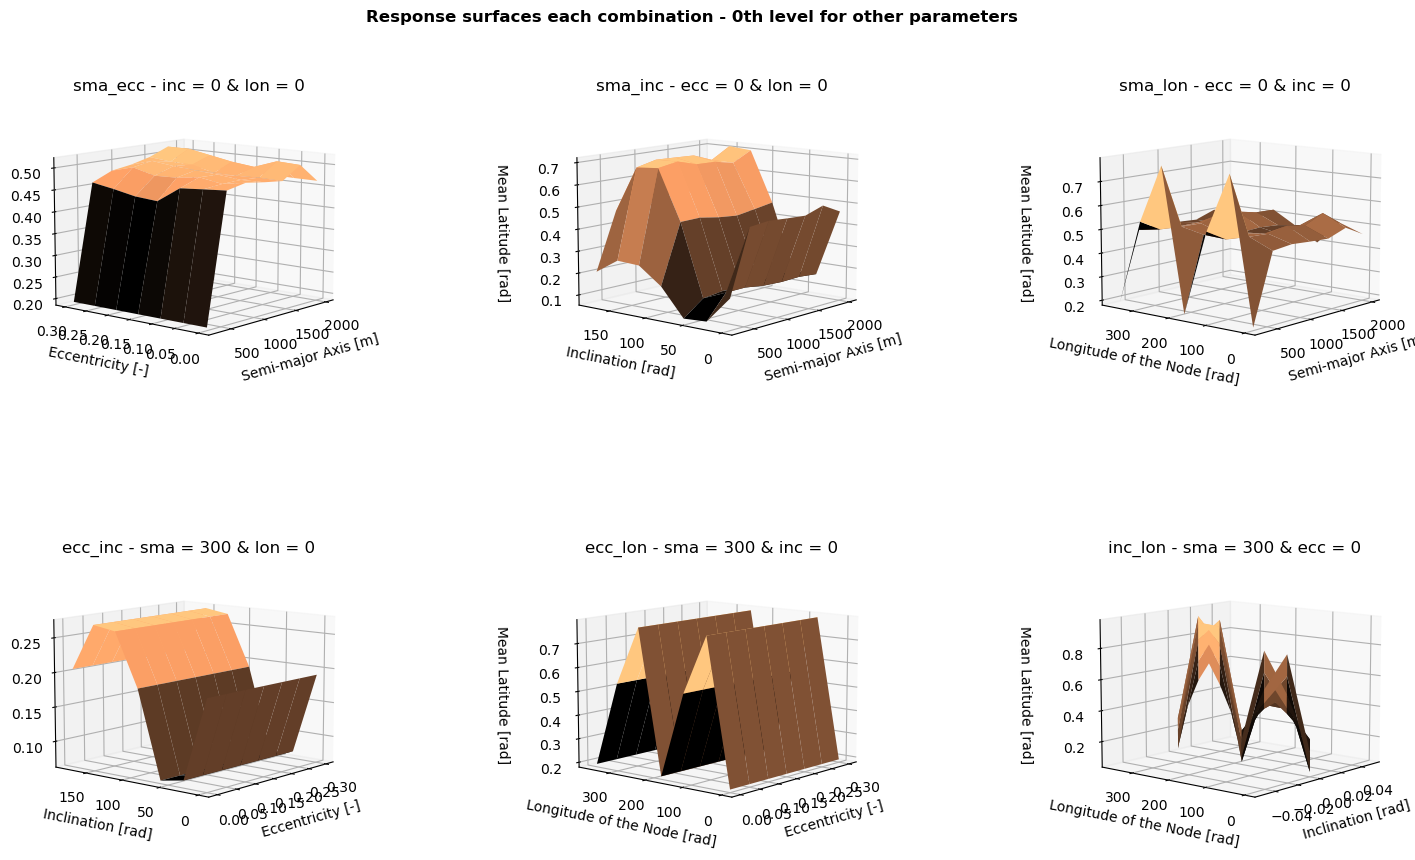

In [27]:
it1, it2, it3, it4, it5, it6 = 0, 0, 0, 0, 0, 0
combi_list = ['sma_ecc', 'sma_inc', 'sma_lon', 'ecc_inc', 'ecc_lon', 'inc_lon']
xlabel_list = ['Semi-major Axis [m]','Semi-major Axis [m]', 'Semi-major Axis [m]', 'Eccentricity [-]', 'Eccentricity [-]', 'Inclination [rad]']
ylabel_list = ['Eccentricity [-]', 'Inclination [rad]', 'Longitude of the Node [rad]', 'Inclination [rad]', 'Longitude of the Node [rad]', 'Longitude of the Node [rad]']
title_list = ['inc = 0 & lon = 0', 'ecc = 0 & lon = 0', 'ecc = 0 & inc = 0', 'sma = 300 & lon = 0', 'sma = 300 & inc = 0', 'sma = 300 & ecc = 0']

objectives = {}
params = {}
for i in combi_list:
    objectives[i] = np.zeros((no_of_levels**2, 2))
    params[i] = np.zeros((no_of_levels**2, 2))
for i in range(len(param_arr)):
    if param_arr[i, 2] == 0 and param_arr[i, 3] == 0:
        objectives['sma_ecc'][it1, :] = objective_arr[i, :] 
        params['sma_ecc'][it1, :] = param_arr[i, [0, 1]]
        it1 += 1
    if param_arr[i, 1] == 0 and param_arr[i, 3] == 0:
        objectives['sma_inc'][it2, :] = objective_arr[i, :] 
        params['sma_inc'][it2, :] = param_arr[i, [0, 2]]
        it2 += 1
    if param_arr[i, 1] == 0 and param_arr[i, 2] == 0:
        objectives['sma_lon'][it3, :] = objective_arr[i, :] 
        params['sma_lon'][it3, :] = param_arr[i, [0, 3]]
        it3 += 1
    if param_arr[i, 0] == 300 and param_arr[i, 3] == 0:
        objectives['ecc_inc'][it4, :] = objective_arr[i, :] 
        params['ecc_inc'][it4, :] = param_arr[i, [1, 2]]
        it4 += 1
    if param_arr[i, 0] == 300 and param_arr[i, 2] == 0:
        objectives['ecc_lon'][it5, :] = objective_arr[i, :] 
        params['ecc_lon'][it5, :] = param_arr[i, [1, 3]]
        it5 += 1
    if param_arr[i, 0] == 300 and param_arr[i, 1] == 0:
        objectives['inc_lon'][it6, :] = objective_arr[i, :] 
        params['inc_lon'][it6, :] = param_arr[i, [1, 3]]
        it6 += 1

fig = plt.figure(figsize=(18, 10))
fig.suptitle('Response surfaces each combination - 0th level for other parameters', fontweight='bold', y=0.95)
for i, combi in enumerate(combi_list):
    ax = fig.add_subplot(2, 3, 1 + i, projection='3d')
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    cmap = ax.plot_surface(params[combi][:, 0].reshape(no_of_levels,
        no_of_levels), params[combi][:, 1].reshape(no_of_levels,
            no_of_levels), objectives[combi][:, 1].reshape(no_of_levels,
                no_of_levels), cmap=plt.get_cmap('copper'))

    ax.set_xlabel(xlabel_list[i], labelpad=5)
    ax.set_ylabel(ylabel_list[i], labelpad=5)
    ax.set_zlabel('Mean Latitude [rad]', labelpad=10)
    ax.set_title('%s - %s '%(combi, title_list[i]), y=1.0, pad=10)
    ax.view_init(10, -140)
